# Lab 4

Francisco Roh

Bryan Calisto

Adecuar la siguiente red neuronal a una red convolucional CNN.

In [49]:
import torch
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from collections import Counter


In [50]:
# Ajustado para cuda
if torch.cuda.is_available():
    cuda_device = torch.device("cuda")
    x = torch.ones(1, device=cuda_device)
    print(x)
else:
    cuda_device = torch.device("cpu")
    print("CUDA device not found.")

tensor([1.], device='cuda:0')


In [51]:
import nltk
nltk.download('stopwords')

ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
!ls -lh .

total 844K
-rw-r--r-- 1 root root 838K Aug 29 20:19 gabriel_garcia_marquez_cien_annos_soledad.txt
drwxr-xr-x 1 root root 4.0K Aug 27 13:23 sample_data


In [53]:
!head -c 1000 './gabriel_garcia_marquez_cien_annos_soledad.txt'

Gabriel García Márquez 



Cien años de soledad 



EDITADO POR "EDICIONES LA CUEVA" 



Para J omi García Ascot 
y María Luisa Elio 



Cien años de soledad 



Gabriel García Márquez 



Muchos años después, frente al pelotón de fusilamiento, el coronel Aureliano Buendía había de 
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. Macondo era entonces 
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas 
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos 
prehistóricos. El mundo era tan reciente, que muchas cosas carecían de nombre, y para 
mencionarlas había que señalarías con el dedo. Todos los años, por el mes de marzo, una familia 
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y 
timbales daban a conocer los nuevos inventos. Primero llevaron el imán. Un gitano corpulento, de 

In [54]:
text = open('./gabriel_garcia_marquez_cien_annos_soledad.txt', 'r').read().lower()
#text = open('./cap1.txt', 'r').read().lower()

In [55]:
def split_tokens(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in sw]
    #tokens = [ss.stem(w) for w in tokens if w not in sw]
    return tokens


In [56]:
tokens = split_tokens(text)

In [57]:
tokens[:20]

['gabriel',
 'garcía',
 'márquez',
 'cien',
 'años',
 'soledad',
 'editado',
 'ediciones',
 'cueva',
 'j',
 'omi',
 'garcía',
 'ascot',
 'maría',
 'luisa',
 'elio',
 'cien',
 'años',
 'soledad',
 'gabriel']

In [58]:
counts = Counter(tokens)

In [59]:
counts

Counter({'gabriel': 184,
         'garcía': 173,
         'márquez': 241,
         'cien': 182,
         'años': 357,
         'soledad': 217,
         'editado': 1,
         'ediciones': 2,
         'cueva': 2,
         'j': 10,
         'omi': 1,
         'ascot': 1,
         'maría': 4,
         'luisa': 1,
         'elio': 1,
         'después': 229,
         'frente': 77,
         'pelotón': 23,
         'fusilamiento': 24,
         'coronel': 312,
         'aureliano': 794,
         'buendía': 406,
         'recordar': 22,
         'aquella': 109,
         'tarde': 149,
         'remota': 12,
         'padre': 117,
         'llevó': 63,
         'conocer': 28,
         'hielo': 29,
         'macondo': 180,
         'entonces': 272,
         'aldea': 33,
         'veinte': 32,
         'casas': 35,
         'barro': 7,
         'cañabrava': 2,
         'construidas': 2,
         'orilla': 4,
         'río': 18,
         'aguas': 8,
         'diáfanas': 2,
         'precipitaban': 

In [60]:
counts_more_than_1 = {k:v for k,v in counts.items() if v > 1}

In [61]:
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v:k for k,v in itot.items()}

In [62]:
tokens_more_than_1 = [w for w in tokens if w in vocab]

### Let's prepare the window for word2vec

In [63]:
def window(tokens, win=2):
    output = []
    for i, w in enumerate(tokens):
        target = ttoi[w]
        window = [tokens[i+j] for j in range(-win, win+1,1)
                  if (i+j >= 0) & (i+j < len(tokens)) & (j != 0)]
       # print(window)
        output += [(target, ttoi[j]) for j in window]
    return output

In [64]:
data_windowed = window(tokens_more_than_1, win=4)

In [65]:
data_windowed

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 8),
 (6, 1),
 (6, 9),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 8),
 (7, 1),
 (7, 9),
 (7, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 1),
 (8, 9),
 (8, 3),
 (8, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 3),
 (1, 4),
 (1, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 1),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 0),
 (3, 7),
 (3, 8),
 (3, 1),
 (3, 9),
 (3, 4),
 (3, 5),
 (3, 0),
 (3, 1),
 (4, 8),
 (4, 1),
 (4, 9),
 (4, 3),
 (4, 5),
 (4, 0),
 (4, 1),
 (4, 2),
 (5, 1),
 (5, 9),
 (5, 3),
 (5, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 4),
 (0, 9),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 1),
 (0, 2),
 (0, 4),
 (0, 10),
 (1, 3),


In [66]:
class text_dataset(Dataset):
    def __init__(self, data_windowed, vocab_size):
        self.data = data_windowed
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x0, y = self.data[idx]
        x =  F.one_hot(torch.tensor(x0), num_classes=self.vocab_size)
        return x, y


In [67]:
dataset = text_dataset(data_windowed, len(vocab))

### Building the network

In [68]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embed(input.to(torch.int64))
        logits = self.expand(hidden)
        return logits

In [69]:
model = Word2Vec(len(vocab), 100).to(cuda_device)

In [70]:
model

Word2Vec(
  (embed): Embedding(7406, 100)
  (expand): Linear(in_features=100, out_features=7406, bias=False)
)

In [71]:
LR = 3e-3
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
BATCH_SIZE = 65536

In [72]:
from tqdm import tqdm  # For progress bars

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        #center, context = center.to(mps_device), context.to(mps_device)

        # Mover los datos al dispositivo CUDA (si está disponible)
        center = center.to(cuda_device).to(torch.float)
        context = context.to(cuda_device).to(torch.float)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)



100%|██████████| 80/80 [06:32<00:00,  4.47s/it]

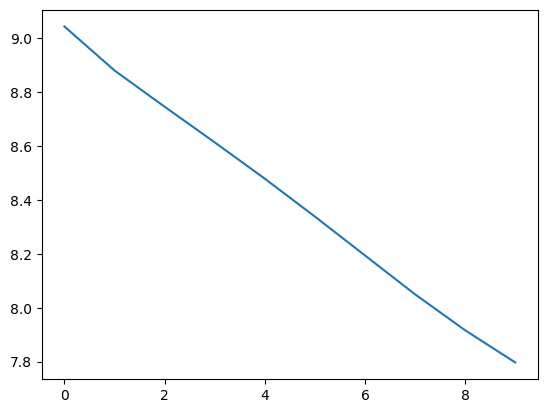

In [73]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

In [74]:
wordvecs = model.expand.weight.cpu().detach().numpy()

In [75]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

# n * (n-1) / 2
def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, itot[i], dists[i]) for i in ind]
    return out

In [76]:
dmat = get_distance_matrix(wordvecs, 'cosine')
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']
#tokens_test = [ss.stem(w) for w in tokens_test if w not in sw]
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")

aureliano ['casa', 'macondo', 'nadie', 'úrsula', 'si', 'hizo', 'dijo', 'buendía', 'entonces', 'tan'] 

coronel ['arcadio', 'aureliano', 'guerra', 'macondo', 'tiempo', 'úrsula', 'noche', 'dio', 'dijo', 'entonces'] 

macondo ['aureliano', 'casa', 'úrsula', 'segundo', 'tiempo', 'hizo', 'hombre', 'nadie', 'entonces', 'tan'] 

casa ['úrsula', 'tiempo', 'aureliano', 'si', 'macondo', 'sino', 'fernanda', 'entonces', 'amaranta', 'sólo'] 

pueblo ['aureliano', 'casa', 'tiempo', 'si', 'nadie', 'amaranta', 'dijo', 'hombre', 'vez', 'entonces'] 

melquíades ['casa', 'amaranta', 'nadie', 'tarde', 'aureliano', 'úrsula', 'entonces', 'dio', 'fernanda', 'mientras'] 

arcadio ['aureliano', 'entonces', 'macondo', 'segundo', 'tarde', 'tiempo', 'nadie', 'úrsula', 'coronel', 'amaranta'] 

úrsula ['casa', 'tiempo', 'amaranta', 'tan', 'aureliano', 'entonces', 'fernanda', 'tarde', 'nadie', 'dijo'] 



In [77]:
wordvecs[0]

array([-0.14121516,  0.12361111,  0.23230311,  0.06839515,  0.21857832,
       -0.13682008,  0.21516854, -0.2155719 ,  0.11637076,  0.12625599,
       -0.01093104, -0.20656016,  0.10011343, -0.10152676,  0.03366606,
       -0.18590334,  0.12186047,  0.24555735,  0.24182884,  0.1091966 ,
        0.07336825, -0.11580326,  0.09222625,  0.19375779,  0.0967622 ,
       -0.11522412, -0.13408811, -0.20059465,  0.21043009, -0.16342166,
        0.22807394, -0.08460957,  0.2297017 ,  0.1362167 ,  0.1488364 ,
       -0.09397186, -0.11471231, -0.13330214, -0.22887059, -0.10700417,
        0.17173377, -0.1396982 ,  0.16227493,  0.11451524,  0.06835094,
        0.08024638, -0.04634329, -0.21090762, -0.07365364, -0.01684697,
        0.0047815 , -0.23609383,  0.10164849, -0.04091398, -0.18014888,
       -0.14513502, -0.18649809,  0.1497929 ,  0.0351214 ,  0.14544185,
        0.09050139, -0.23162007,  0.10748839,  0.15367588,  0.19243865,
       -0.12908687,  0.07008439, -0.23271891, -0.12847053,  0.13

In [78]:
from tqdm import tqdm  # For progress bars
EPOCHS = 50

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        #center, context = center.to(mps_device), context.to(mps_device)

        # Mover los datos al dispositivo CUDA (si está disponible)
        center = center.to(cuda_device).to(torch.float)
        context = context.to(cuda_device).to(torch.float)

        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)



100%|██████████| 80/80 [06:35<00:00,  4.94s/it]

100%|██████████| 400/400 [32:42<00:00,  4.47s/it]

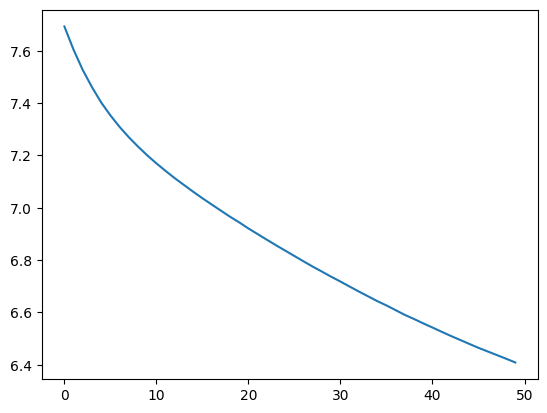

In [79]:
plt.plot(running_loss)

In [80]:
wordvecs_50_epochs = model.expand.weight.cpu().detach().numpy()
dmat_50_epochs = get_distance_matrix(wordvecs_50_epochs, 'cosine')

In [81]:
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat_50_epochs)], "\n")

aureliano ['úrsula', 'casa', 'buendía', 'segundo', 'entonces', 'arcadio', 'josé', 'tiempo', 'si', 'amaranta'] 

coronel ['buendía', 'aureliano', 'guerra', 'josé', 'dijo', 'entonces', 'arcadio', 'úrsula', 'muerte', 'segundo'] 

macondo ['aureliano', 'entonces', 'segundo', 'casa', 'tiempo', 'buendía', 'sólo', 'después', 'úrsula', 'nadie'] 

casa ['úrsula', 'aureliano', 'entonces', 'amaranta', 'tiempo', 'si', 'sino', 'tarde', 'segundo', 'fernanda'] 

pueblo ['aureliano', 'casa', 'tiempo', 'macondo', 'arcadio', 'buendía', 'úrsula', 'segundo', 'entonces', 'si'] 

melquíades ['mientras', 'casa', 'úrsula', 'cuarto', 'dio', 'arcadio', 'josé', 'aureliano', 'mundo', 'entonces'] 

arcadio ['josé', 'buendía', 'aureliano', 'segundo', 'úrsula', 'entonces', 'casa', 'mientras', 'tiempo', 'amaranta'] 

úrsula ['amaranta', 'casa', 'aureliano', 'tiempo', 'entonces', 'tarde', 'si', 'nadie', 'mientras', 'arcadio'] 



In [82]:
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

aureliano ['casa', 'macondo', 'nadie', 'úrsula', 'si', 'hizo', 'dijo', 'buendía', 'entonces', 'tan'] 

coronel ['arcadio', 'aureliano', 'guerra', 'macondo', 'tiempo', 'úrsula', 'noche', 'dio', 'dijo', 'entonces'] 

macondo ['aureliano', 'casa', 'úrsula', 'segundo', 'tiempo', 'hizo', 'hombre', 'nadie', 'entonces', 'tan'] 

casa ['úrsula', 'tiempo', 'aureliano', 'si', 'macondo', 'sino', 'fernanda', 'entonces', 'amaranta', 'sólo'] 

pueblo ['aureliano', 'casa', 'tiempo', 'si', 'nadie', 'amaranta', 'dijo', 'hombre', 'vez', 'entonces'] 

melquíades ['casa', 'amaranta', 'nadie', 'tarde', 'aureliano', 'úrsula', 'entonces', 'dio', 'fernanda', 'mientras'] 

arcadio ['aureliano', 'entonces', 'macondo', 'segundo', 'tarde', 'tiempo', 'nadie', 'úrsula', 'coronel', 'amaranta'] 

úrsula ['casa', 'tiempo', 'amaranta', 'tan', 'aureliano', 'entonces', 'fernanda', 'tarde', 'nadie', 'dijo'] 



## Creación del modelo CNN para predicción de palabras

### Modificación del modelo

In [91]:
class WordCNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_kernels, kernel_size, num_classes):
        super(WordCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.conv1 = nn.Conv1d(embedding_size, num_kernels, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(num_kernels, num_kernels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(num_kernels, num_kernels, kernel_size=3, padding=1)
        self.fc = nn.Linear(num_kernels, num_classes)

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, x.shape[2]).squeeze(2)
        logits = self.fc(x)
        return logits


### Generador de secuencias para CNN

Se ajustar para entrenar la red con el objetivo de realizar una predicción y no solo buscar similitudes

In [92]:
def create_sequences(tokens, seq_length):
    inputs = []
    targets = []
    for i in range(len(tokens) - seq_length):
        inputs.append([ttoi[token] for token in tokens[i:i+seq_length]])
        targets.append(ttoi[tokens[i+seq_length]])
    return torch.tensor(inputs), torch.tensor(targets)

seq_length = 8  # Longitud de la secuencia de entrada
inputs, targets = create_sequences(tokens_more_than_1, seq_length)


### Entrenamiento de la CNN

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

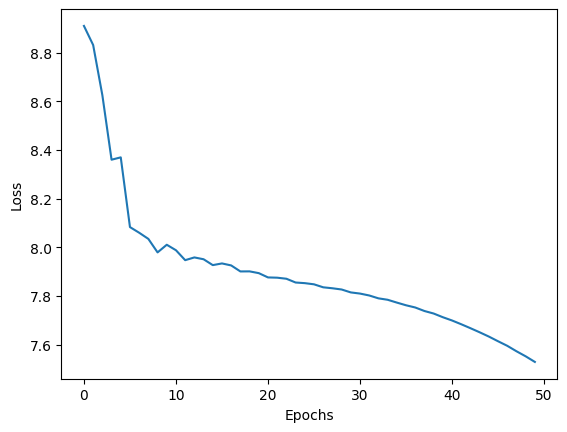

In [93]:
# Crear el dataset y dataloader
class TextSequenceDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

dataset = TextSequenceDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Instanciar el modelo
model = WordCNN(len(vocab), embedding_size=100, num_kernels=128, kernel_size=3, num_classes=len(vocab)).to(cuda_device)

# Definir el optimizador y la función de pérdida
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()


EPOCHS = 50
progress_bar = tqdm(range(EPOCHS * len(dataloader)))

# Entrenamiento
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for input_seq, target in dataloader:
        input_seq, target = input_seq.to(cuda_device), target.to(cuda_device)

        optimizer.zero_grad()
        logits = model(input_seq)
        loss = loss_fn(logits, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)

# Visualizar la pérdida
plt.plot(running_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


### Predicción de palabras

In [94]:
def predict_next_word(model, input_sequence, top_k=20):
    model.eval()
    with torch.no_grad():
        input_seq_tensor = torch.tensor([ttoi[word] for word in input_sequence]).unsqueeze(0).to(cuda_device)
        logits = model(input_seq_tensor)
        probs = F.softmax(logits, dim=1)
        top_probs, top_indices = probs.topk(top_k, dim=1)
        predictions = [(itot[idx.item()], prob.item()) for idx, prob in zip(top_indices[0], top_probs[0])]
    return predictions

# Ejemplo de secuencia para predecir
sequence = ['josé', 'arcadio', 'buendía', 'ignoraba', 'completo']
predictions = predict_next_word(model, sequence)
print(f"Given sequence: {' '.join(sequence)}")
print(f"Predicted next words: {predictions}")


Given sequence: josé arcadio buendía ignoraba completo
Predicted next words: [('arcadio', 0.01653587445616722), ('aureliano', 0.012288202531635761), ('segundo', 0.007648948114365339), ('buendía', 0.0067931730300188065), ('años', 0.0061097173020243645), ('piedad', 0.004609506111592054), ('gerineldo', 0.004322731867432594), ('josé', 0.004040020052343607), ('dijo', 0.003768578637391329), ('entonces', 0.003515042131766677), ('coronel', 0.0034744045697152615), ('sólo', 0.0034267890732735395), ('rebeca', 0.0031462714541703463), ('hizo', 0.0030742741655558348), ('cotes', 0.0029912195168435574), ('amaranta', 0.0029441185761243105), ('dos', 0.002891241107136011), ('café', 0.002886745845898986), ('noche', 0.002819294575601816), ('volvió', 0.002723895013332367)]


### Predicción de oraciones

In [95]:
def predict_sentence(model, start_text, max_length=20, top_k=15):
    model.eval()  # Establecer el modelo en modo de evaluación

    # Convertir el texto inicial en una lista de palabras en minúsculas
    generated_sequence = start_text.lower().split()

    for _ in range(max_length):
        # Asegurarse de que la secuencia es lo suficientemente larga
        current_sequence = generated_sequence[-seq_length:] if len(generated_sequence) >= seq_length else generated_sequence

        # Convertir la secuencia actual en tensor de índices
        input_seq_tensor = torch.tensor([ttoi.get(word, ttoi.get('<UNK>', 0)) for word in current_sequence]).unsqueeze(0).to(cuda_device)

        # Predecir la siguiente palabra
        with torch.no_grad():
            logits = model(input_seq_tensor)
            probs = F.softmax(logits, dim=1)
            top_probs, top_indices = torch.topk(probs, top_k, dim=1)
            next_word_idx = top_indices[0, torch.multinomial(top_probs, num_samples=1).item()]
            next_word = itot[next_word_idx.item()]

        # Añadir la palabra generada a la secuencia
        generated_sequence.append(next_word)

        # Opción de terminar la oración si se encuentra un punto
        if next_word == '.':
            break

    return ' '.join(generated_sequence)


# Ejemplo de texto inicial
start_text = 'pelotón de fusilamiento'

# Generar una oración
generated_sentence = predict_sentence(model, start_text, max_length=20, top_k=25)
print(f"Oración generada: {generated_sentence}")

start_text = 'macondo fue una aldea más ordenada'

# Generar una oración
generated_sentence = predict_sentence(model, start_text, max_length=20, top_k=25)
print(f"Oración generada: {generated_sentence}")

Oración generada: pelotón de fusilamiento días sólo guerra casa amaranta noche arcadio josé arcadio arcadio arcadio buendía dijo hizo josé arcadio buendía sólo aureliano buendía
Oración generada: macondo fue una aldea más ordenada buendía tan coronel aureliano buendía úrsula cien años soledad gabriel garcía márquez úrsula esfuerzos preocupó produjo último vez dos casa


Se generan oraciones con un mejor léxico pero el entendimiento y coherencia del contexto sigue siendo bajo. Aunque se haya entrenado con todo el libro y 3 capas convolucionales.